### 7-4．トピック抽出のためのデータ準備
#### 全記事の形態素解析

In [1]:
# Janomeのインストール
!pip install janome

In [1]:
import os
import re
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.tokenfilter import POSKeepFilter

# 記事フォルダの指定
dirs = ['it-life-hack', 'movie-enter']

# 単語とラベルを格納するリストを生成
docterm = [] # 説明変数
label = [] # 目的変数
tmp1 = []
tmp2 = ''

# 形態素解析の準備
# オブジェクト生成
t = Tokenizer()
# 名詞の単語のみ抽出するフィルターを生成
token_filters = [POSKeepFilter(['名詞'])]
# フィルターを搭載した解析フレームワークの生成
a = Analyzer([], t, token_filters)

# 各フォルダのファイルを1つずつ読み込んで表示
for i, d in enumerate(dirs):
    # ファイルの取得
    files = os.listdir('./data/' + d)
    
    for file in files:
        # ファイルオープンと読み込み
        f = open('./data/' + d + '/' + file, 'r', encoding='utf-8')
        text = f.read()
        
        # 正規表現で不要な文字列を除去して表示
        reg_text = re.sub(r'[0-9a-zA-Z]+', '', text)
        reg_text = re.sub(r'[:;/+\.-]', '', reg_text)
        reg_text = re.sub(r'[\s\n]', '', reg_text)
        reg_text = reg_text.replace('\n','')        
        
        # フィルタ付き形態素解析
        for token in a.analyze(reg_text):
            tmp1.append(token.surface)
            tmp2 = ' '.join(tmp1)
        # 記事ごとに単語を格納
        docterm.append(tmp2)
        tmp1 = []
        
        # 記事ごとにラベルの格納
        label.append(i)
        
        # ファイルクローズ
        f.close()

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd

# 単語のTF-IDFを計算
tv = TfidfVectorizer(min_df=0.05, max_df=0.5)
docterm_tv = tv.fit_transform(np.array(docterm))
docterm_tfidf = docterm_tv.toarray()

# データフレーム形式で先頭5行まで表示
docterm_tfidf = pd.DataFrame(docterm_tfidf)
docterm_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,497,498,499,500,501,502,503,504,505,506
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.140271,0.000000
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.041122,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.365883,0.0,0.0,0.034061,0.0,0.0,0.0,0.034309,0.000000
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.056238,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.124622,0.0,0.0,0.0,0.000000,0.097902


In [3]:
# データセットにラベル列を結合
label = pd.DataFrame(label)
label = label.rename(columns={0:'label'})

docterm_df = pd.concat([docterm_tfidf, label], axis=1)
docterm_df.head()

,0,1,2,3,4,5,6,7,8,9,...,498,499,500,501,502,503,504,505,506,label
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.140271,0.000000,0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0
2,0.0,0.0,0.0,0.041122,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.365883,0.0,0.0,0.034061,0.0,0.0,0.0,0.034309,0.000000,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.056238,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.124622,0.0,0.0,0.0,0.000000,0.097902,0


#### 類似度の計算

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

# labelが0の単語文書行列のみ選択
docterm_0 = docterm_df[docterm_df['label'] == 0]
docterm_0 = docterm_0.drop('label', axis=1)

# 単語ペアのコサイン類似度を計算
sim0 = cosine_similarity(docterm_0.T)
sim0_df = pd.DataFrame(sim0)

# 類似度を行列形式で確認
sim0_df

,0,1,2,3,4,5,6,7,8,9,...,497,498,499,500,501,502,503,504,505,506
0,1.000000,0.000000,0.000000,0.155156,0.000000,0.055320,0.000000,0.043896,0.113562,0.000000,...,0.000000,0.000000,0.111072,0.000000,0.000000,0.146878,0.067592,0.015477,0.018005,0.078362
1,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.184860,0.250185,0.042842,...,0.000000,0.000000,0.000000,0.334841,0.151063,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.100779,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.124585,0.000000,0.126987,0.253078,0.000000,0.000000
3,0.155156,0.000000,0.000000,1.000000,0.000000,0.027540,0.185999,0.019417,0.103317,0.000000,...,0.000000,0.219708,0.118544,0.065468,0.010728,0.051270,0.068213,0.117281,0.079754,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.056933,0.041681,0.000000,0.036957,0.025481,...,0.009494,0.000000,0.010423,0.030202,0.041761,0.041977,0.000000,0.016574,0.020493,0.070330
5,0.055320,0.000000,0.000000,0.027540,0.056933,1.000000,0.000000,0.124353,0.041928,0.016330,...,0.000000,0.108990,0.016673,0.041267,0.356336,0.000000,0.024808,0.022356,0.133563,0.141060
6,0.000000,0.000000,0.000000,0.185999,0.041681,0.000000,1.000000,0.134900,0.141514,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.164301,0.022761,0.000000,0.109039,0.036468,0.081728
7,0.043896,0.184860,0.100779,0.019417,0.000000,0.124353,0.134900,1.000000,0.000000,0.000000,...,0.118622,0.072733,0.019598,0.005640,0.012556,0.000000,0.244796,0.025505,0.004717,0.012495
8,0.113562,0.250185,0.000000,0.103317,0.036957,0.041928,0.141514,0.000000,1.000000,0.116336,...,0.009298,0.143923,0.139648,0.364165,0.147936,0.000000,0.018818,0.159488,0.130804,0.105691
9,0.000000,0.042842,0.000000,0.000000,0.025481,0.016330,0.000000,0.000000,0.116336,1.000000,...,0.000000,0.000000,0.039761,0.039225,0.000000,0.000000,0.021077,0.000000,0.095659,0.008270


#### 共起語リストの作成

In [5]:
# 類似度行列をリスト形式へ変換
sim0_stack = sim0_df.stack()

# 単語インデックスと類似度を分割
index = pd.Series(sim0_stack.index.values)
value = pd.Series(sim0_stack.values)

print(index.head())
print(value.head())

0    (0, 0)
1    (0, 1)
2    (0, 2)
3    (0, 3)
4    (0, 4)
dtype: object
0    1.000000
1    0.000000
2    0.000000
3    0.155156
4    0.000000
dtype: float64


In [6]:
tmp3 = []
tmp4 = []
for i in range(len(index)):
    # 類似度が0.5以上0.9以下の単語ペアを抽出
    if value[i] >=0.5 and value[i] <= 0.9:
        # 単語ペアを抽出
        tmp1 = str(index[i][0]) + ' ' + str(index[i][1])
        tmp2 = [int(s) for s in tmp1.split()]
        tmp3.append(tmp2)
        # 類似度を抽出
        tmp4 = np.append(tmp4, value[i])

# 共起語リストを作成
tmp3 = pd.DataFrame(tmp3)
tmp3 = tmp3.rename(columns={0:'node1', 1:'node2'})
tmp4 = pd.DataFrame(tmp4)
tmp4 = tmp4.rename(columns={0:'weight'})
sim0_list = pd.concat([tmp3, tmp4], axis=1)

# 作成したリストを確認
sim0_list.head()

,node1,node2,weight
0,1,148,0.539952
1,2,76,0.559733
2,2,101,0.564668
3,2,310,0.522363
4,4,61,0.521283


In [7]:
# 練習問題5
# labelが1の単語文書行列のみ選択
docterm_1 = docterm_df[docterm_df['label'] == 1]
docterm_1 = docterm_1.drop('label', axis=1)

# 単語ペアのコサイン類似度を計算
sim1 = cosine_similarity(docterm_1.T)
sim1_df = pd.DataFrame(sim1)

# 類似度を行列形式で確認
sim1_df

,0,1,2,3,4,5,6,7,8,9,...,497,498,499,500,501,502,503,504,505,506
0,1.000000,0.020351,0.157256,0.103388,0.000000,0.000000,0.061962,0.062154,0.073794,0.064370,...,0.138581,0.0,0.0,0.049541,0.023284,0.000000,0.105989,0.000000,0.142215,0.240337
1,0.020351,1.000000,0.109777,0.052887,0.000000,0.050628,0.063129,0.063864,0.155105,0.076726,...,0.025167,0.0,0.0,0.097312,0.092807,0.015529,0.004187,0.000000,0.057902,0.123801
2,0.157256,0.109777,1.000000,0.117946,0.052325,0.050844,0.055315,0.063515,0.100650,0.217393,...,0.502812,0.0,0.0,0.249436,0.003845,0.000000,0.003127,0.000000,0.086483,0.237121
3,0.103388,0.052887,0.117946,1.000000,0.000000,0.000000,0.050548,0.000000,0.081133,0.000000,...,0.088532,0.0,0.0,0.000000,0.148354,0.094445,0.098515,0.000000,0.000000,0.068841
4,0.000000,0.000000,0.052325,0.000000,1.000000,0.052980,0.120871,0.008906,0.075461,0.089360,...,0.000000,0.0,0.0,0.000000,0.013621,0.000000,0.041333,0.000000,0.000000,0.002236
5,0.000000,0.050628,0.050844,0.000000,0.052980,1.000000,0.041396,0.007816,0.003862,0.008115,...,0.000000,0.0,0.0,0.077805,0.007683,0.000000,0.000000,0.000000,0.000000,0.024043
6,0.061962,0.063129,0.055315,0.050548,0.120871,0.041396,1.000000,0.245917,0.208667,0.149250,...,0.017183,0.0,0.0,0.059807,0.320213,0.000000,0.160390,0.000000,0.000000,0.179289
7,0.062154,0.063864,0.063515,0.000000,0.008906,0.007816,0.245917,1.000000,0.017629,0.336784,...,0.118864,0.0,0.0,0.000000,0.109797,0.095293,0.073319,0.122075,0.000000,0.114754
8,0.073794,0.155105,0.100650,0.081133,0.075461,0.003862,0.208667,0.017629,1.000000,0.061067,...,0.016908,0.0,0.0,0.038367,0.037966,0.062103,0.003466,0.000000,0.000000,0.092717
9,0.064370,0.076726,0.217393,0.000000,0.089360,0.008115,0.149250,0.336784,0.061067,1.000000,...,0.256489,0.0,0.0,0.234124,0.102917,0.064364,0.025822,0.126737,0.000000,0.126287


In [8]:
# 練習問題6
# 類似度行列をリスト形式へ変換
sim1_stack = sim1_df.stack()

# 単語インデックスと類似度を分割
index = pd.Series(sim1_stack.index.values)
value = pd.Series(sim1_stack.values)

print(index.head())
print(value.head())

0    (0, 0)
1    (0, 1)
2    (0, 2)
3    (0, 3)
4    (0, 4)
dtype: object
0    1.000000
1    0.020351
2    0.157256
3    0.103388
4    0.000000
dtype: float64


In [9]:
tmp3 = []
tmp4 = []
for i in range(len(index)):
    # 類似度が0.5以上0.9以下の単語ペアを抽出
    if value[i] >=0.5 and value[i] <= 0.9:
        # 単語ペアを抽出
        tmp1 = str(index[i][0]) + ' ' + str(index[i][1])
        tmp2 = [int(s) for s in tmp1.split()]
        tmp3.append(tmp2)
        # 類似度を抽出
        tmp4 = np.append(tmp4, value[i])

# 共起語リストを作成
tmp3 = pd.DataFrame(tmp3)
tmp3 = tmp3.rename(columns={0:'node1', 1:'node2'})
tmp4 = pd.DataFrame(tmp4)
tmp4 = tmp4.rename(columns={0:'weight'})
sim1_list = pd.concat([tmp3, tmp4], axis=1)

# 作成したリストを確認
sim1_list.head()

,node1,node2,weight
0,2,497,0.502812
1,3,89,0.541855
2,4,383,0.662268
3,4,446,0.615523
4,5,155,0.563130


In [10]:
sim1_list.to_csv('sim1_list.csv', index=False)

##### === モデル作成はここから ======================

In [10]:
import networkx as nx

# 無向ネットワークの作成
G_corlist = nx.from_pandas_edgelist(sim1_list, 'node1', 'node2', ['weight'], nx.Graph)

print(G_corlist.nodes()) # ノードの確認
print(G_corlist.edges(data=True)) # エッジの確認

[2, 497, 3, 89, 4, 383, 446, 5, 155, 7, 163, 218, 221, 12, 457, 13, 267, 19, 25, 38, 397, 433, 493, 26, 484, 27, 391, 28, 341, 35, 36, 368, 39, 272, 40, 242, 44, 275, 45, 194, 334, 440, 46, 88, 127, 50, 157, 51, 87, 131, 277, 402, 53, 146, 55, 114, 56, 111, 343, 57, 67, 202, 58, 468, 59, 61, 137, 314, 62, 117, 133, 251, 403, 64, 96, 66, 144, 187, 214, 416, 69, 165, 71, 220, 72, 212, 274, 453, 502, 73, 237, 80, 119, 84, 283, 305, 371, 90, 93, 196, 324, 472, 478, 97, 173, 100, 455, 102, 439, 106, 265, 109, 128, 115, 337, 116, 404, 168, 189, 199, 252, 125, 462, 366, 129, 300, 388, 135, 405, 136, 142, 140, 301, 141, 209, 408, 167, 207, 150, 477, 152, 327, 480, 158, 302, 308, 160, 162, 378, 336, 164, 450, 172, 489, 179, 180, 182, 213, 320, 192, 414, 280, 323, 365, 470, 195, 348, 240, 243, 331, 421, 197, 330, 469, 200, 247, 204, 250, 358, 411, 486, 349, 413, 351, 233, 376, 234, 309, 236, 281, 244, 344, 260, 263, 491, 266, 401, 276, 459, 285, 313, 347, 500, 326, 352, 333, 409, 342, 452, 441, 

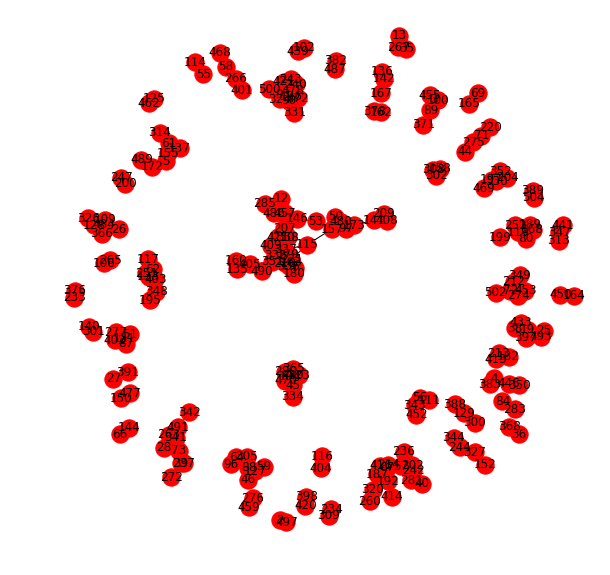

In [15]:
# 作成したネットワークを可視化
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))
pos = nx.spring_layout(G_corlist) # レイアウトの設定
nx.draw_networkx(G_corlist, pos)
plt.axis('off')
plt.show()

In [16]:
# 平均クラスタ係数の計算
print(nx.average_clustering(G_corlist))

# 媒介中心性の計算
bc = nx.betweenness_centrality(G_corlist)

for k, v in sorted(bc.items(), key=lambda x: -x[1]):
    print(str(k) + ': ' + str(v))

0.18253660203201486
337: 0.011421175399670025
157: 0.008747226489161975
115: 0.006990669625078227
351: 0.005077658303464756
207: 0.004935426978437732
221: 0.0039540308357512675
173: 0.0038402457757296467
405: 0.002688172043010753
141: 0.002688172043010753
146: 0.0018418956590999598
457: 0.0016783296353188825
53: 0.0016712180690675313
196: 0.00136542072025943
486: 0.00136542072025943
67: 0.0004906980713432327
341: 0.00046936337258917906
218: 0.00043380554133242295
19: 0.0004266939750810719
187: 0.0004266939750810719
72: 0.00038402457757296467
119: 0.00038402457757296467
324: 0.00038402457757296467
403: 0.0003413551800648575
194: 0.00029868578255675033
440: 0.00029868578255675033
336: 0.00029868578255675033
45: 0.0002560163850486431
57: 0.0002560163850486431
320: 0.0002560163850486431
51: 0.00021334698754053595
61: 0.00021334698754053595
62: 0.00021334698754053595
73: 0.00021334698754053595
348: 0.00021334698754053595
330: 0.00021334698754053595
491: 0.00021334698754053595
163: 0.0001849

In [17]:
print(tv.get_feature_names()[337])
print(tv.get_feature_names()[157])
print(tv.get_feature_names()[115])
print(tv.get_feature_names()[351])
print(tv.get_feature_names()[207])

映画
ランキング
ニュース
月日
作品


In [20]:
from networkx.algorithms.community import greedy_modularity_communities

# コミュニティ抽出
cm_corlist = list(greedy_modularity_communities(G_corlist))

# 各コミュニティに属するノードの表示
cm_corlist

[frozenset({12, 53, 146, 207, 250, 285, 333, 337, 358, 409, 411, 457, 486}),
 frozenset({7, 135, 160, 163, 179, 180, 218, 221, 336, 351, 405, 490}),
 frozenset({90, 93, 196, 240, 243, 324, 331, 421, 472, 478, 500}),
 frozenset({50, 97, 115, 141, 157, 173, 209, 408, 480}),
 frozenset({45, 194, 280, 323, 334, 365, 440, 470}),
 frozenset({57, 67, 187, 202, 214, 260, 320, 416}),
 frozenset({62, 117, 133, 195, 251, 348, 403}),
 frozenset({28, 73, 237, 263, 341, 342, 491}),
 frozenset({19, 25, 38, 397, 433, 493}),
 frozenset({80, 119, 168, 189, 199, 252}),
 frozenset({72, 212, 274, 349, 453, 502}),
 frozenset({51, 87, 131, 277, 402}),
 frozenset({5, 61, 137, 155, 314}),
 frozenset({46, 59, 88, 127, 305}),
 frozenset({197, 204, 330, 352, 469}),
 frozenset({40, 236, 242, 281}),
 frozenset({56, 111, 343, 452}),
 frozenset({4, 350, 383, 446}),
 frozenset({13, 35, 267}),
 frozenset({3, 89, 371}),
 frozenset({109, 128, 366}),
 frozenset({129, 300, 388}),
 frozenset({136, 142, 167}),
 frozenset({15

##### === モデル作成はここまで ======================